In [1]:

def plot_metric_histograms(df, columns=None, bins=30, skew_threshold=1.0):
    """
    Plots histograms for each metric column with skewness displayed.
    If no columns provided, uses all numeric columns.
    """
    if columns is None:
        columns = df.select_dtypes(include='number').columns

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*2))
    axes = axes.flatten()

    for i, col in enumerate(columns):
        data = df[col].dropna()
        sk = skew(data)
        sns.histplot(data, bins=bins, kde=True, ax=axes[i])
        axes[i].set_title(f"{col}\nSkewness: {sk:.2f}")
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_original_vs_transformed(df, original_columns):
    """
    Plots side-by-side histograms of original and transformed versions of each metric.
    Transformed versions are expected to be in columns named '<original>_log' or '<original>_yj'.
    """
    for col in original_columns:
        transformed_col = None
        if col + '_log' in df.columns:
            transformed_col = col + '_log'
        elif col + '_yj' in df.columns:
            transformed_col = col + '_yj'
        else:
            continue  # Skip if no transformed version exists

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))

        # Original
        sns.histplot(df[col].dropna(), bins=30, kde=True, ax=axes[0])
        orig_skew = skew(df[col].dropna())
        axes[0].set_title(f"Original: {col}\nSkewness: {orig_skew:.2f}")
        axes[0].set_ylabel("Frequency")

        # Transformed
        sns.histplot(df[transformed_col].dropna(), bins=30, kde=True, ax=axes[1])
        trans_skew = skew(df[transformed_col].dropna())
        axes[1].set_title(f"Transformed: {transformed_col}\nSkewness: {trans_skew:.2f}")
        axes[1].set_ylabel("Frequency")

        plt.tight_layout()
        plt.show()

def select_best_transformed_version(df):
    selected_cols = []

    # Get all base column names (before _log or _yj)
    base_cols = set(col.replace('_log', '').replace('_yj', '') for col in df.columns)

    for base in base_cols:
        log_col = base + '_log'
        yj_col = base + '_yj'

        if log_col in df.columns:
            selected_cols.append(log_col)
        elif yj_col in df.columns:
            selected_cols.append(yj_col)
        elif base in df.columns:
            selected_cols.append(base)
        # else: skip — no usable version of this metric

    return df[selected_cols].copy()


def safe_log_transform_old(df, columns, skew_threshold=1.0):
    """
    Applies log1p transformation to highly skewed, positive-only columns.
    For mixed or negative columns, applies Yeo-Johnson transformation instead.

    Returns a new DataFrame with log-transformed columns (originals unchanged).
    """
    from sklearn.preprocessing import PowerTransformer

    transformed_df = df.copy()
    skew_vals = df[columns].apply(skew)

    for col in skew_vals.index:
        if abs(skew_vals[col]) > skew_threshold:
            col_data = df[col]
            if (col_data <= 0).any():
                # Mixed or negative values: use Yeo-Johnson
                pt = PowerTransformer(method='yeo-johnson', standardize=False)
                transformed = pt.fit_transform(col_data.values.reshape(-1, 1)).flatten()
                transformed_df[col + '_yj'] = transformed
            else:
                # Positive-only: safe to use log1p
                transformed_df[col + '_log'] = np.log1p(col_data)
    
    return transformed_df

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.interpolate import interp1d
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import MinMaxScaler, StandardScaler  
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from PlottingFunctions import *

## Read dataframe of results for all gauges

In [3]:
all_events =[]
for file in os.listdir("../DanishRainData_Outputs/5mins/"):
    df = pd.read_csv(f"../DanishRainData_Outputs/5mins/{file}")
    df['event_num']=range(0, len(df))
    all_events.append(df)
all_events_df = pd.concat(all_events)   

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (83,143) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
all_events_df.rename(columns={'4th_w_peak':"Huff quartile"}, inplace=True)
all_events_df.rename(columns={'4th_w_peak_DMC_10':"Huff quartile_DMC_10"}, inplace=True)
all_events_df.rename(columns={'3rd_w_peak':"Huff third"}, inplace=True)
all_events_df.rename(columns={'3rd_w_peak_DMC_10':"Huff third_DMC_10"}, inplace=True)
all_events_df.rename(columns={'5th_w_peak':"Huff quintile"}, inplace=True)
all_events_df.rename(columns={'5th_w_peak_DMC_10':"Huff quintile_DMC_10"}, inplace=True)
# all_events_df.rename(columns={'3rd_ARR':"3rd (w/ D50)"}, inplace=True)
# all_events_df.rename(columns={'3rd_ARR_DMC_10':"3rd (w/ D50)_DMC_10"}, inplace=True)

### Remove events which are too small

In [5]:
print(len(all_events_df))
all_events_df = all_events_df[all_events_df['total_precip']>4].copy()
print(len(all_events_df))

539546
516453


### Remove normalisations we're not interested in (rn)

In [6]:
print(len(all_events_df.columns))
columns_to_drop = [col for col in all_events_df.columns if '_norm' in col or '_dblnorm' in col or 'DMC_100' in col]
all_events_df.drop(columns=columns_to_drop, inplace=True)
print(len(all_events_df.columns))
all_events_df.reset_index(inplace=True, drop=True)

189
129


### Remove columns we're not interested in (rn)

In [7]:
del all_events_df['BSC'], all_events_df['BSC_DMC_10']
del all_events_df['duration']
del all_events_df['total_precip']

### Delete problematic (np.nan) columns

In [8]:
cols_to_keep = all_events_df.columns
cols_to_del = ['min_intensity', 'min_intensity_DMC_10', 
               'min_intensity', 'min_intensity_DMC_10', # doesnt make sense, as for DMC it is always 0.1
               'frac_q1', 'frac_q2', 'frac_q3', 'frac_q4', ## loads have NAN when we don't interpolate
               'frac_q1_DMC_10', 'frac_q2_DMC_10', 'frac_q3_DMC_10', 'frac_q4_DMC_10',   ## loads have NAN when we don't interpolate
              'heaviest_half', 'heaviest_half_DMC_10', # lots of events dont have a 'run' over threshold
#               '3rd_com',  '3rd_com_DMC_10',  # this metric doesnt calculate properly
              ]
#                '3rd_rcg','3rd_rcg_DMC_10',]

cols_to_keep = [x for x in cols_to_keep if x not in cols_to_del]  

all_events_df = all_events_df[cols_to_keep]

In [9]:
# bad_indices = all_events_df[all_events_df['third_ppr_DMC_10'].isnull()].index
# all_events_df[all_events_df['third_ppr_DMC_10'].isnull()][['third_ppr_DMC_10', 'third_ppr']]

In [10]:
# Find columns with nan for 60 mins
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

Columns with at least one NaN value:
['asymm_d', 'Event Loading', 'lorentz_asymetry', 'Event Loading_DMC_10', 'lorentz_asymetry_DMC_10']


In [11]:
# # Find indices of rows with any NaNs in the 60-minute data
bad_indices = all_events_df[all_events_df.isnull().any(axis=1)].index
print(len(bad_indices))
# Drop rows at these indices from all dataframes
all_events_df = all_events_df.drop(index=bad_indices)

del all_events_df['event_num']
all_events_df.reset_index(drop=True, inplace=True)

# Recheck for NANS
columns_with_nan = all_events_df.columns[all_events_df.isnull().any()].tolist()
print("Columns with at least one NaN value:")
print(columns_with_nan)

20
Columns with at least one NaN value:
[]


## Check skewness of variables

In [12]:
metric_columns = all_events_df.columns
metric_columns = metric_columns.drop(['gauge_num', "start_time", "end_time"])
all_events_df = all_events_df[metric_columns]

In [13]:
# plot_metric_histograms(all_events_df, columns=log_columns)

In [14]:
transformed_all_events_df = safe_log_transform(all_events_df, metric_columns)
transformed_all_events_df2 = select_best_transformed_version(transformed_all_events_df)

In [15]:
# original_metric_columns = [col for col in all_events_df.columns 
#                            if not (col.endswith('_log') or col.endswith('_yj')) 
#                            and all_events_df[col].dtype.kind in 'fi']  # float/int only

# plot_original_vs_transformed(transformed_all_events_df, original_metric_columns)

## Standardise Data

In [16]:
metric_columns = transformed_all_events_df2.columns
standard_scaler = MinMaxScaler()
transformed_scaled = standard_scaler.fit_transform(transformed_all_events_df2[metric_columns])
# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
transformed_scaled = pd.DataFrame(transformed_scaled, columns=metric_columns)

In [17]:
# metric_columns = all_events_df.columns
# standard_scaler = MinMaxScaler()
# original_scaled = standard_scaler.fit_transform(all_events_df[metric_columns])

# # Convert scaled values back to DataFrame and concatenate with original non-numeric columns
# original_scaled = pd.DataFrame(original_scaled, columns=metric_columns)

In [18]:
metric_base_names = {col.replace(suffix, '') for col in all_events_df.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [19]:
pearsonsr_ls = []
spearmansr_ls = []
metric_names = []
suffixes = ['', '_log', '_yj']

for i, base_name in enumerate(metric_base_names):
    found_pair = False
    for suffix in suffixes:
        col1 = base_name + suffix
        col2 = base_name + '_DMC_10' + suffix

        if col1 in transformed_scaled.columns and col2 in transformed_scaled.columns:
            x = transformed_scaled[col1]
            y = transformed_scaled[col2]
            
            pearsonsr_ls.append(pearsonr(x, y)[0])
            spearmansr_ls.append(spearmanr(x, y)[0])
            metric_names.append(base_name + suffix)
            found_pair = True
            break  # stop after finding first matching suffix pair
            
    if not found_pair:
        print(f"No matching pair found for metric '{base_name}' with any suffix")

In [20]:
metric_scores = pd.DataFrame({'Metric':metric_names,
                             "pearsonsr": pearsonsr_ls, "spearmansr": spearmansr_ls})
metric_scores.sort_values(by="pearsonsr", ascending=False, inplace=True)
sorted_metrics = metric_scores.sort_values(by="pearsonsr", ascending=False)['Metric'].values
cleaned_sorted_metrics = [m.replace('_log', '').replace('_yj', '') for m in sorted_metrics]

## Create correlation matrix

In [21]:
# # Define suffixes to consider, ordered by preference
# suffixes = ['', '_log', '_yj']

# n_metrics = len(metric_base_names)
# n_cols = 6
# n_rows = int(np.ceil(n_metrics / n_cols))

# fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_cols, 4.5 * n_rows), sharex=True, sharey=True)
# axs = axs.flatten()

# for i, base_name in enumerate(cleaned_sorted_metrics):
    
#     if base_name == 'Huff quartile':
#         bins=4
#     elif base_name == 'Huff quintile':
#         bins=5   
#     elif base_name == 'Huff third' or base_name =='3rd (w/ D50)' or base_name == '3rd_rcg' or base_name == '3rd_ARR':
#         bins=3
#     elif base_name == 'BSC_Index':
#         bins=5
#     else:
#         bins=30
    
#     found_pair = False
#     for suffix in suffixes:
#         col1 = base_name + suffix
#         col2 = base_name + '_DMC_10' + suffix

#         if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
#             ax = axs[i]
#             x = scaled_all_events_df[col1]
#             y = scaled_all_events_df[col2]

#             sns.histplot(x=x, y=y, bins=bins, pmax=0.9, ax=ax, cmap="viridis", cbar=False)
#             ax.set_title(f"{base_name} {suffix if suffix else '(raw)'}", fontsize=30)
#             ax.set_xlabel("Raw")
#             ax.set_ylabel("DMC")
# #             ax.set_title(f"{base_name}_{suffix}", fontsize=30)
#             found_pair = True
            
#             min_val = min(np.min(x), np.min(y))
#             max_val = max(np.max(x), np.max(y))
#             ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='solid', linewidth=3.5, label='1:1 Line')
            
#             pearsons_r = pearsonr(x, y)[0]
#             spearmans_r = spearmanr(x, y)[0]
            
#             ax.annotate(f"{pearsons_r:.3f}", 
#                     xy=(0.80, 0.1), xycoords='axes fraction',
#                     fontsize=25, color='black', 
#                     # ha='right', va='bottom',
#                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
#             ax.annotate(f"{spearmans_r:.3f}", 
#                     xy=(0.06, 0.86), xycoords='axes fraction',
#                     fontsize=25, color='black', 
#                     # ha='right', va='bottom',
#                     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))    
            
#             ax.tick_params(axis='both', which='major', labelsize=25)
#             ax.xaxis.label.set_size(25)  # Increase x-axis label font size
#             ax.yaxis.label.set_size(25)  # Increase y-axis label font size
            
#             break  # stop after finding first matching suffix pair
            
#     if not found_pair:
#         print(f"No matching pair found for metric '{base_name}' with any suffix")

# # Remove unused axes if any
# for j in range(i + 1, len(axs)):
#     fig.delaxes(axs[j])

# plt.tight_layout()
# plt.show()

### Plot Bland Altman Plot

In [22]:
# plot_bland_altman_grid(bland_altman_data, plots_per_row=6)

## Cohen's D

In [23]:
import numpy as np
from scipy.stats import spearmanr

def cohens_d(x, y):
    n1, n2 = len(x), len(y)
    s1, s2 = np.std(x, ddof=1), np.std(y, ddof=1)
    s_pooled = np.sqrt(((n1 -1)*s1**2 + (n2 -1)*s2**2) / (n1 + n2 -2))
    d = (np.mean(x) - np.mean(y)) / s_pooled
    d=abs(d)
    if d<=0.2:
        meaning = "Negligible"
    elif d>0.2 and d <=0.5:
        meaning="Small"
    elif d >0.5 and d <= 0.8:
        meaning = 'Moderate'
    elif d>0.8:
        meaning = 'Large'
    return d, meaning

def instability_index(x, y):
    rho, _ = spearmanr(x, y)
    instability_index = 1 - rho
    
    if instability_index<=0.05:
        meaning = "Very low" # "Very stable"
    elif instability_index>0.05 and instability_index <=0.15:
        meaning= "Low"# "Stable"
    elif instability_index >0.15 and instability_index <= 0.35:
        meaning = 'Moderate' # 'Moderate instability'
    elif instability_index >0.35 and instability_index <= 0.60:
        meaning = "High" # 'High instability'
    elif instability_index>0.6:
        meaning = "Very high" # 'Very unstable'
    
    return instability_index, meaning

def cliffs_delta(x, y):
    from itertools import product
    x, y = np.asarray(x), np.asarray(y)
    n_x, n_y = len(x), len(y)
    greater = sum(1 for a, b in product(x, y) if a > b)
    less = sum(1 for a, b in product(x, y) if a < b)
    delta = (greater - less) / (n_x * n_y)
    abs_delta = abs(delta)
    
    if abs_delta < 0.147:
        meaning = "Negligible"
    elif abs_delta < 0.33:
        meaning = "Small"
    elif abs_delta < 0.474:
        meaning = "Medium"
    else:
        meaning = "Large"
    
    return abs_delta, meaning

import numpy as np
from scipy.stats import mannwhitneyu

def cliffs_delta_fast(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)

    # Mann-Whitney U test (two-sided, but we just use U statistic)
    U, _ = mannwhitneyu(x, y, alternative='two-sided')
    # Compute delta
    delta = (2 * U) / (n_x * n_y) - 1
    abs_delta = abs(delta)

    if abs_delta < 0.147:
        meaning = "Negligible"
    elif abs_delta < 0.33:
        meaning = "Small"
    elif abs_delta < 0.474:
        meaning = "Medium"
    else:
        meaning = "Large"
    
    return abs_delta, meaning


from scipy.stats import kendalltau

def ordinal_ranking_instability(x, y):
    tau, _ = kendalltau(x, y)
    instability = 1 - tau
    if instability <= 0.05:
        meaning = "Very low"
    elif instability <= 0.15:
        meaning = "Low"
    elif instability <= 0.35:
        meaning = "Moderate"
    elif instability <= 0.60:
        meaning = "High"
    else:
        meaning = "Very high"
    return instability, meaning


# # Example for one metric
# for metric in cleaned_sorted_metrics:
#     metric_fine = all_events_df[metric]
#     metric_coarse = all_events_df[f'{metric}_DMC_10']

#     d, meaning = cohens_d(metric_fine, metric_coarse)
#     instab, translation = instability_index(metric_fine, metric_coarse)

# #     print(f"{metric}: Cohen's d: {d:.2f}, is {meaning}. Instability is: {instab:.2f} ")
#     print(f"{metric}: \n Sensitivity of event rankings to DMC transformation (Cohen's D): {meaning} ({d:.2f}).  \n Sensitivity of event numerical meanings to DMC transformation (instability_index): {translation} ({instab:.2f}) ")

In [24]:
categorical_metric_list = []

for metric in cleaned_sorted_metrics:
    unique_vals = all_events_df[metric].dropna().unique()
    if len(unique_vals) < 6:
        categorical_metric_list.append(metric)

print("Detected categorical metrics:", categorical_metric_list)


Detected categorical metrics: ['third_ppr', 'Huff quartile', '3rd_ARR', 'Huff third', 'Huff quintile', '3rd_rcg', 'BSC_Index']


In [ ]:
print(r"\begin{tabular}{llll}")
print(r"\hline")
print(r"Metric & Metric type & Ranking Instability & Numerical Instability \\")
print(r"\hline")

for metric in cleaned_sorted_metrics:
    x = all_events_df[metric]
    y = all_events_df[f'{metric}_DMC_10']

    if metric in categorical_metric_list:
        instab_rank, meaning_rank = ordinal_ranking_instability(x, y)
        delta, meaning_num = cliffs_delta_fast(x, y)
        metric_type = 'categorical'
        print(f"{metric} & {metric_type} & {meaning_rank} ({instab_rank:.2f}) & {meaning_num} ({delta:.2f}) \\\\")
    else:
        d, meaning = cohens_d(x, y)
        instab, translation = instability_index(x, y)
        metric_type = 'continuous'
        print(f"{metric} & {metric_type} & {meaning} ({d:.2f}) & {translation} ({instab:.2f}) \\\\")

print(r"\hline")
print(r"\end{tabular}")


In [25]:
# Initialize a list to store results
results = []

for metric in cleaned_sorted_metrics:
    x = all_events_df[metric]
    y = all_events_df[f'{metric}_DMC_10']

    if metric in categorical_metric_list:
        instab_rank, meaning_rank = ordinal_ranking_instability(x, y)
        delta, meaning_num = cliffs_delta_fast(x, y)
        metric_type = 'categorical'
        results.append({
            'Metric': metric,
            'Metric Type': metric_type,
            'Ranking Instability': instab_rank,
            'Ranking Interpretation': meaning_rank,
            'Numerical Instability': delta,
            'Numerical Interpretation': meaning_num
        })
    else:
        d, meaning = cohens_d(x, y)
        instab, translation = instability_index(x, y)
        metric_type = 'continuous'
        results.append({
            'Metric': metric,
            'Metric Type': metric_type,
            'Ranking Instability': d,
            'Ranking Interpretation': meaning,
            'Numerical Instability': instab,
            'Numerical Interpretation': translation
        })

# Create a DataFrame from the results
df_results = pd.DataFrame(results)


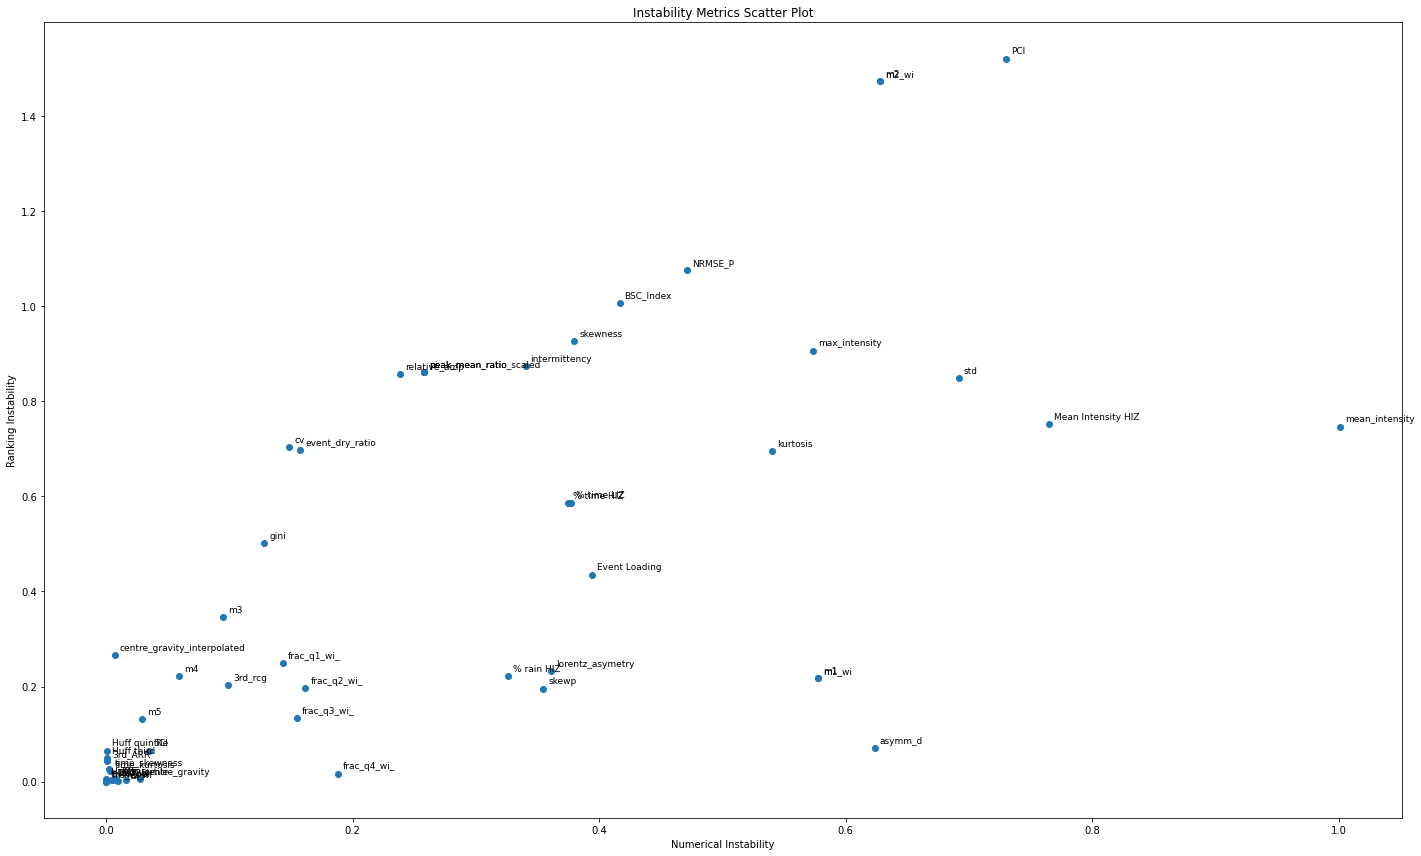

In [34]:
import matplotlib.pyplot as plt

# Create scatter plot
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(df_results['Numerical Instability'], df_results['Ranking Instability'])

# Annotate each point with the metric name, offsetting labels
for i, row in df_results.iterrows():
    ax.annotate(row['Metric'],
                (row['Numerical Instability'], row['Ranking Instability']),
                textcoords="offset points",
                xytext=(5,5),
                ha='left',
                fontsize=9)

# Set plot labels and title
ax.set_xlabel('Numerical Instability')
ax.set_ylabel('Ranking Instability')
ax.set_title('Instability Metrics Scatter Plot')

plt.tight_layout()
plt.show()


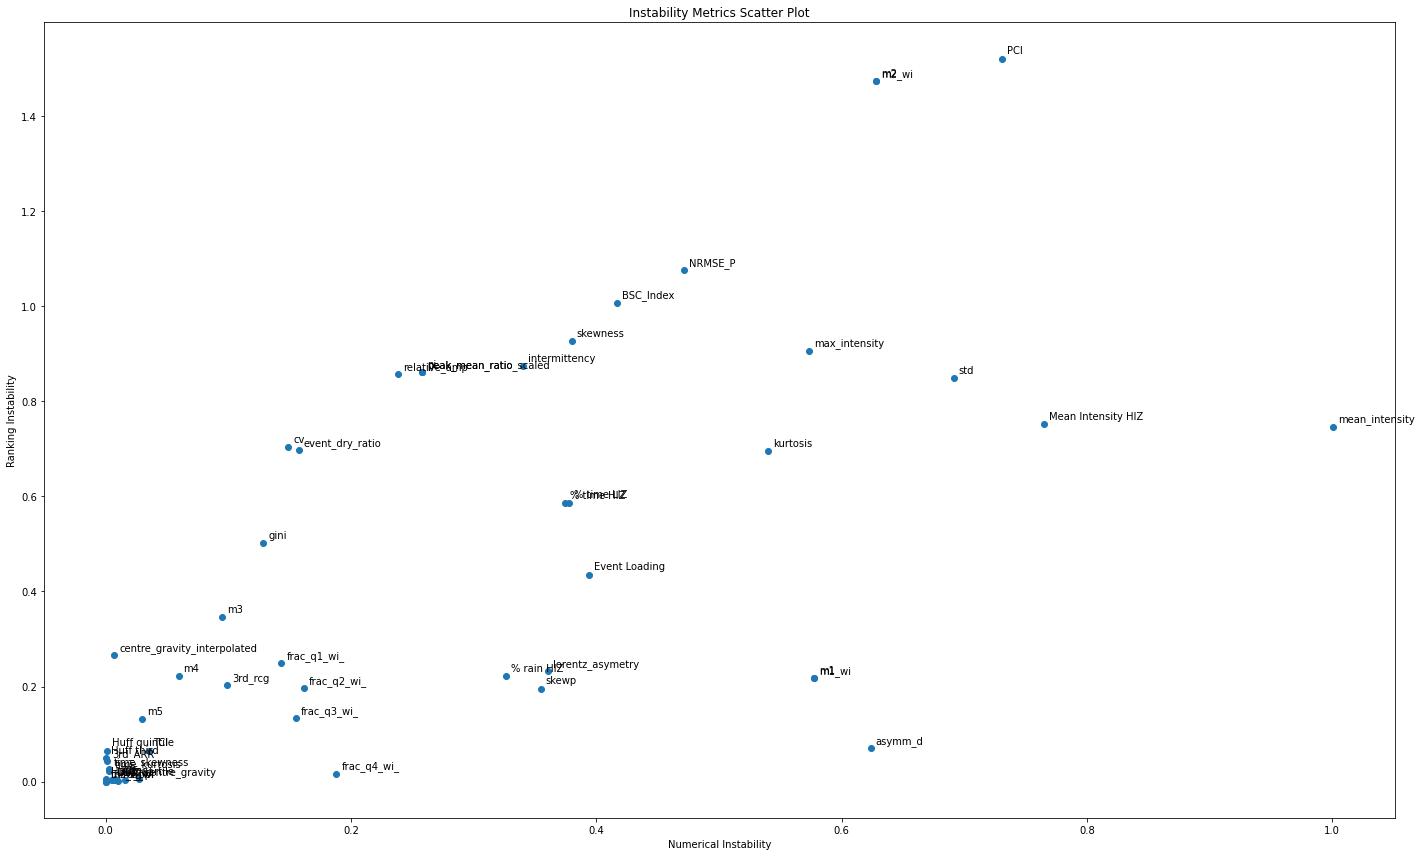

In [30]:
# Create scatter plot
fig, ax = plt.subplots(figsize=(20, 12))
ax.scatter(df_results['Numerical Instability'], df_results['Ranking Instability'])

# Annotate each point with the metric name
for i, row in df_results.iterrows():
    ax.annotate(row['Metric'], (row['Numerical Instability'], row['Ranking Instability']),
                textcoords="offset points", xytext=(5,5), ha='left')

# Set plot labels and title
ax.set_xlabel('Numerical Instability')
ax.set_ylabel('Ranking Instability')
ax.set_title('Instability Metrics Scatter Plot')

# Display the plot
plt.tight_layout()
plt.show()


In [73]:
# print(r"\begin{tabular}{llll}")
# print(r"\hline")
# print(r"Metric & Ranking Instability & Numerical Instability \\")
# print(r"\hline")

# for metric in cleaned_sorted_metrics:
#     x = all_events_df[metric]
#     y = all_events_df[f'{metric}_DMC_10']

#     if metric in categorical_metric_list:
#         instab_rank, meaning_rank = ordinal_ranking_instability(x, y)
#         delta, meaning_num = cliffs_delta_fast(x, y)
#         print(f"{metric} & {meaning_rank} ({instab_rank:.2f}) & {meaning_num} ({delta:.2f}) \\\\")
#     else:
#         d, meaning = cohens_d(x, y)
#         instab, translation = instability_index(x, y)
#         print(f"{metric} & {meaning} ({d:.2f}) & {translation} ({instab:.2f}) \\\\")

# print(r"\hline")
# print(r"\end{tabular}")


\begin{tabular}{llll}
\hline
Metric & Ranking Instability & Numerical Instability \\
\hline
third_ppr & Very low (0.00) & Negligible (0.00) \\
m3_wi & Negligible (0.00) & Very low (0.00) \\
time_skewness & Negligible (0.03) & Very low (0.00) \\
time_kurtosis & Negligible (0.02) & Very low (0.00) \\
Huff quartile & Very low (0.01) & Negligible (0.00) \\
T75 & Negligible (0.01) & Very low (0.01) \\
D50 & Negligible (0.00) & Very low (0.01) \\
T50 & Negligible (0.00) & Very low (0.01) \\
centre_gravity_interpolated & Small (0.27) & Very low (0.01) \\
m4_wi & Negligible (0.00) & Very low (0.01) \\
m5_wi & Negligible (0.00) & Very low (0.01) \\
centre_gravity & Negligible (0.01) & Very low (0.03) \\
m5 & Negligible (0.13) & Very low (0.03) \\
3rd_ARR & Very low (0.04) & Negligible (0.00) \\
TCI & Negligible (0.07) & Very low (0.04) \\
Huff third & Very low (0.05) & Negligible (0.00) \\
T25 & Negligible (0.00) & Very low (0.02) \\
Huff quintile & Low (0.07) & Negligible (0.00) \\
m4 & Small 

In [70]:
# for metric in cleaned_sorted_metrics:
#     x = all_events_df[metric]
#     y = all_events_df[f'{metric}_DMC_10']
#     print(f"{metric}:")
#     if metric in categorical_metric_list:
#         instab_rank, meaning_rank = ordinal_ranking_instability(x, y)
#         delta, meaning_num = cliffs_delta_fast(x, y)
#         print(f"  Ranking Instability (Kendall's τ): {meaning_rank} ({instab_rank:.2f})")
#         print(f"  Numerical Instability (Cliff’s Delta): {meaning_num} ({delta:.2f})\n")

#     else:
#         d, meaning = cohens_d(x, y)
#         instab, translation = instability_index(x, y)
#         print(f"{base_name}: \n Sensitivity of event rankings to DMC transformation: {meaning}.  \n Sensitivity of event numerical meanings to DMC transformation: {translation} ")


third_ppr:
  Ranking Instability (Kendall's τ): Very low (0.00)
  Numerical Instability (Cliff’s Delta): Negligible (0.00)

m3_wi:
BSC_Index: 
 Sensitivity of event rankings to DMC transformation: Negligible.  
 Sensitivity of event numerical meanings to DMC transformation: Very low 
time_skewness:
BSC_Index: 
 Sensitivity of event rankings to DMC transformation: Negligible.  
 Sensitivity of event numerical meanings to DMC transformation: Very low 
time_kurtosis:
BSC_Index: 
 Sensitivity of event rankings to DMC transformation: Negligible.  
 Sensitivity of event numerical meanings to DMC transformation: Very low 
Huff quartile:
  Ranking Instability (Kendall's τ): Very low (0.01)
  Numerical Instability (Cliff’s Delta): Negligible (0.00)

T75:
BSC_Index: 
 Sensitivity of event rankings to DMC transformation: Negligible.  
 Sensitivity of event numerical meanings to DMC transformation: Very low 
D50:
BSC_Index: 
 Sensitivity of event rankings to DMC transformation: Negligible.  
 Sens

In [126]:
for i, base_name in enumerate(cleaned_sorted_metrics):
    
    found_pair = False
    for suffix in suffixes:
        col1 = base_name + suffix
        col2 = base_name + '_DMC_10' + suffix
        if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
            found_pair = True
            d, meaning = cohens_d(scaled_all_events_df[col1], scaled_all_events_df[col2])
            instab = instability_index(scaled_all_events_df[col1], scaled_all_events_df[col2])
#             print(f"{base_name}:   Cohen's d: {d:.2f}, is {meaning}. Instability is: {instab} ")
            print(f"{base_name}: \n Sensitivity of event rankings to DMC transformation: {meaning}.  \n Sensitivity of event numerical meanings to DMC transformation: {translation} ")
            break